<a href="https://colab.research.google.com/github/hamdansyaif/DeepLearning/blob/main/Week_8_UTS/CNN_FishClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deskripsi Tugas
1. Buat pipeline end‑to‑end untuk regresi model machine learning:
a. Pengumpulan & pembersihan data (Pandas), Preprocessing data dan juga Augmentasi Data
b. Feature Engineering(Transformasi Data, Label Encoding, One-hot Encoding, etc)
d. Model‑model yang akan dijalankan dengan modul TensorFlow/PyTorch untuk CNN
2. Gunakan Matriks Evaluasi Klasifikasi (Accuracy, Precision, Recall, F1-Score, AUC-ROC) serta visualisasikan confusion matrix! Jelaskan matriks mana terbaik!

Analisa:
1. Arsitektur CNN dengan X lapisan konvolusi menghasilkan akurasi training 98% tetapi akurasi validasi 62%. Jelaskan fenomena vanishing gradient yang mungkin terjadi pada lapisan awal, dan bagaimana cara memitigasinya! Mengapa penambahan Batch Normalization setelah lapisan konvolusi ke-Y justru memperburuk generalisasi, serta strategi alternatif untuk menstabilkan pembelajaran?
2. Ketika melatih CNN dari nol, loss training stagnan di nilai tinggi setelah XXX(3 digit epoch) epoch. Identifikasi tiga penyebab potensial terkait laju pembelajaran (learning rate), inisialisasi berat, atau kompleksitas model! Mengapa penggunaan Cyclic Learning Rate dapat membantu model keluar dari local minima, dan bagaimana momentum pada optimizer SGD memengaruhi konvergensi?
3. Pada klasifikasi spesies ikan menggunakan CNN, penggunaan fungsi aktivasi ReLU tidak menunjukkan peningkatan akurasi setelah 50 epoch, meskipun learning rate telah dioptimasi. Jelaskan fenomena dying ReLU yang mungkin terjadi dan bagaimana hal ini mengganggu aliran gradien selama backpropagation!
4. Pada pelatihan CNN untuk klasifikasi XX spesies ikan, grafik AUC-ROC menunjukkan satu kelas (Spesies X) stagnan di 0.55 sementara kelas lain mencapai >0.85 setelah YYY epoch. Analisis mengapa class-weighted loss function gagal meningkatkan kinerja Spesies X, dan identifikasi tiga faktor penyebab potensial terkait karakteristik data dan arsitektur model!
5. Pada arsitektur CNN untuk klasifikasi ikan, peningkatan kompleksitas model  justru menyebabkan penurunan akurasi validasi dari 85% ke 65%, meskipun akurasi training mencapai 98%. Jelaskan fenomena overfitting yang terjadi, dan mengapa penambahan kapasitas model tidak selalu meningkatkan generalisasi! Identifikasi 3 kesalahan desain arsitektur yang memicu degradasi performa.

In [2]:
%pip install numpy pandas matplotlib scikit-learn tensorflow
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D, GaussianNoise, ActivityRegularization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from google.colab import drive
from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

warnings.filterwarnings('ignore')

# Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
print(os.listdir('/content/drive/MyDrive'))

['Colab Notebooks', 'Sertifikat Peserta Open Mind EIRRG 2024', 'Abu.jpg', 'RegresiUTSTelkom(1).csv', 'RegresiUTSTelkom.csv', 'fish_image_dataset']


🔍 Memeriksa gambar di: /content/drive/MyDrive/fish_image_dataset/train


Memproses train: 100%|██████████| 31/31 [03:03<00:00,  5.93s/it]


✅ Gambar valid: 8791, ❌ Gambar tidak valid: 0
------------------------------------------------------------
🔍 Memeriksa gambar di: /content/drive/MyDrive/fish_image_dataset/val


Memproses val: 100%|██████████| 31/31 [07:00<00:00, 13.56s/it]


✅ Gambar valid: 2746, ❌ Gambar tidak valid: 0
------------------------------------------------------------
🔍 Memeriksa gambar di: /content/drive/MyDrive/fish_image_dataset/test


Memproses test: 100%|██████████| 31/31 [06:09<00:00, 11.91s/it]


✅ Gambar valid: 1755, ❌ Gambar tidak valid: 0
------------------------------------------------------------
📊 Distribusi kelas:
                       Train  Validation  Test
Fourfinger Threadfin     191          60    38
Glass Perchlet           396         124    76
Climbing Perch           152          48    30
Freshwater Eel           260          81    53
Goby                     607         189   124
Bangus                   171          52    34
Catfish                  313          97    62
Black Spotted Barb       199          62    40
Big Head Carp            200          63    43
Gourami                  311          97    63
Jaguar Gapote            229          72    44
Indo-Pacific Tarpon      196          57    39
Indian Carp              262          81    53
Gold Fish                206          65    41
Long-Snouted Pipefish    256          81    52
Knifefish                318         100    65
Grass Carp              1222         378   238
Janitor Fish             28

<Figure size 1200x700 with 0 Axes>

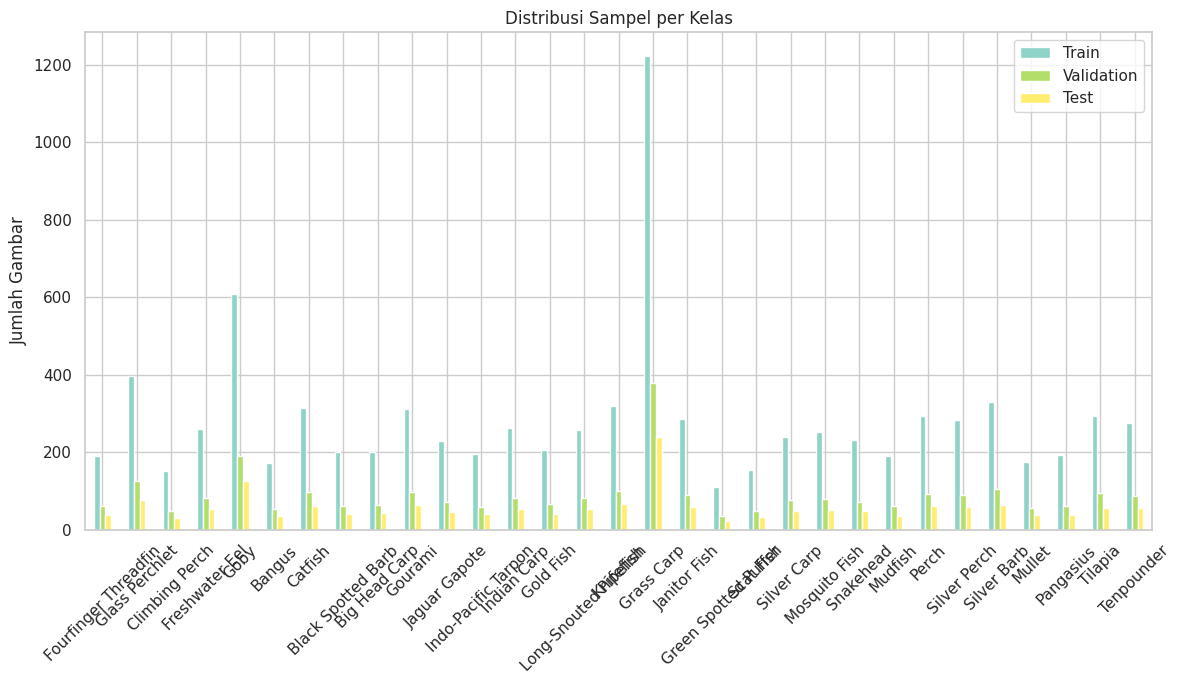

Total gambar tidak valid ditemukan: 0
⚠️ Menghapus gambar tidak valid...


0it [00:00, ?it/s]

✅ Selesai menghapus.


In [6]:
# Path dataset
dataset_path = Path('/content/drive/MyDrive/fish_image_dataset')
train_path = dataset_path / 'train'
val_path = dataset_path / 'val'
test_path = dataset_path / 'test'

# Fungsi pemeriksaan gambar yang mengembalikan daftar gambar tidak valid
def check_images_in_dir(directory, min_size=(64, 64)):
    fish_types = []
    valid_count = 0
    invalid_count = 0
    invalid_image_paths = []

    print(f'🔍 Memeriksa gambar di: {directory}')
    for fish_type_dir in tqdm(list(directory.iterdir()), desc=f"Memproses {directory.name}"):
        if fish_type_dir.is_dir():
            fish_types.append(fish_type_dir.name)
            for img_path in fish_type_dir.glob("*"):
                try:
                    img_raw = tf.io.read_file(str(img_path))
                    img_tensor = tf.io.decode_image(img_raw, channels=3)
                    if img_tensor.shape[0] < min_size[0] or img_tensor.shape[1] < min_size[1]:
                        raise ValueError("Ukuran gambar terlalu kecil")
                    valid_count += 1
                except Exception as e:
                    print(f"❌ Gambar tidak valid: {img_path.name} | Error: {e}")
                    invalid_count += 1
                    invalid_image_paths.append(img_path)

    print(f"✅ Gambar valid: {valid_count}, ❌ Gambar tidak valid: {invalid_count}")
    print("-" * 60)
    return fish_types, invalid_image_paths

# Fungsi menghitung distribusi kelas
def get_class_distribution(directory, fish_types):
    return {fish: len(list((directory / fish).glob("*"))) for fish in fish_types}

def load_and_check_dataset():
    fish_train, invalid_train = check_images_in_dir(train_path)
    fish_val, invalid_val = check_images_in_dir(val_path)
    fish_test, invalid_test = check_images_in_dir(test_path)

    dist_train = get_class_distribution(train_path, fish_train)
    dist_val = get_class_distribution(val_path, fish_val)
    dist_test = get_class_distribution(test_path, fish_test)

    df = pd.DataFrame([dist_train, dist_val, dist_test], index=['Train', 'Validation', 'Test']).T
    print("📊 Distribusi kelas:")
    print(df)

    # Visualisasi
    plt.figure(figsize=(12, 7))
    sns.set(style="whitegrid")
    df.plot(kind='bar', figsize=(12, 7), colormap='Set3')
    plt.title("Distribusi Sampel per Kelas")
    plt.ylabel("Jumlah Gambar")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Gabungkan semua gambar tidak valid dari ketiga set
    all_invalid_images = invalid_train + invalid_val + invalid_test
    print(f"Total gambar tidak valid ditemukan: {len(all_invalid_images)}")

    return df, fish_train, all_invalid_images

def hapus_gambar_tidak_valid(invalid_image_paths):
    print("⚠️ Menghapus gambar tidak valid...")
    for path in tqdm(invalid_image_paths):
        try:
            os.remove(path)
        except Exception as e:
            print(f"❌ Gagal hapus {path}: {e}")
    print("✅ Selesai menghapus.")


df_distribution, label_list, invalid_image_paths = load_and_check_dataset()

# Lanjut hapus jika yakin:
hapus_gambar_tidak_valid(invalid_image_paths)


Banyak gambar tidak valid:
- Mereka bisa menyebabkan error saat augmentasi atau training.
- Gambar terlalu kecil umumnya tidak memberi kontribusi berarti secara fitur visual.
- Format tidak didukung akan menyebabkan keras ImageDataGenerator gagal memproses.

# Feature Engineering

In [7]:
# ======= PARAMETER ==========
IMG_SIZE = 224  # Ukuran ideal untuk pretrained CNN
BATCH_SIZE = 32

# ======= AUGMENTASI UNTUK TRAINING ==========
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.1],  # Tambahan dari versi 1
    fill_mode='reflect'           # Lebih natural dari 'nearest'
)

# ======= HANYA RESCALE UNTUK VALIDASI & TEST ==========
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ======= GENERATOR ==========
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ======= LABEL INFO ==========
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"\nJumlah kelas: {num_classes}")
print(f"Nama kelas: {class_names}")
print(f"Mapping kelas: {class_indices}")

# ======= (OPSIONAL) LABEL ENCODING UNTUK PREDIKSI MANUAL ==========
label_encoder = LabelEncoder()
label_encoder.fit(class_names)
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nMapping kategori (LabelEncoder):")
for category, code in category_mapping.items():
    print(f"{category}: {code}")

Found 8791 images belonging to 31 classes.
Found 2746 images belonging to 31 classes.
Found 1755 images belonging to 31 classes.

Jumlah kelas: 31
Nama kelas: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']
Mapping kelas: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 


Visualisasi augmentasi data...


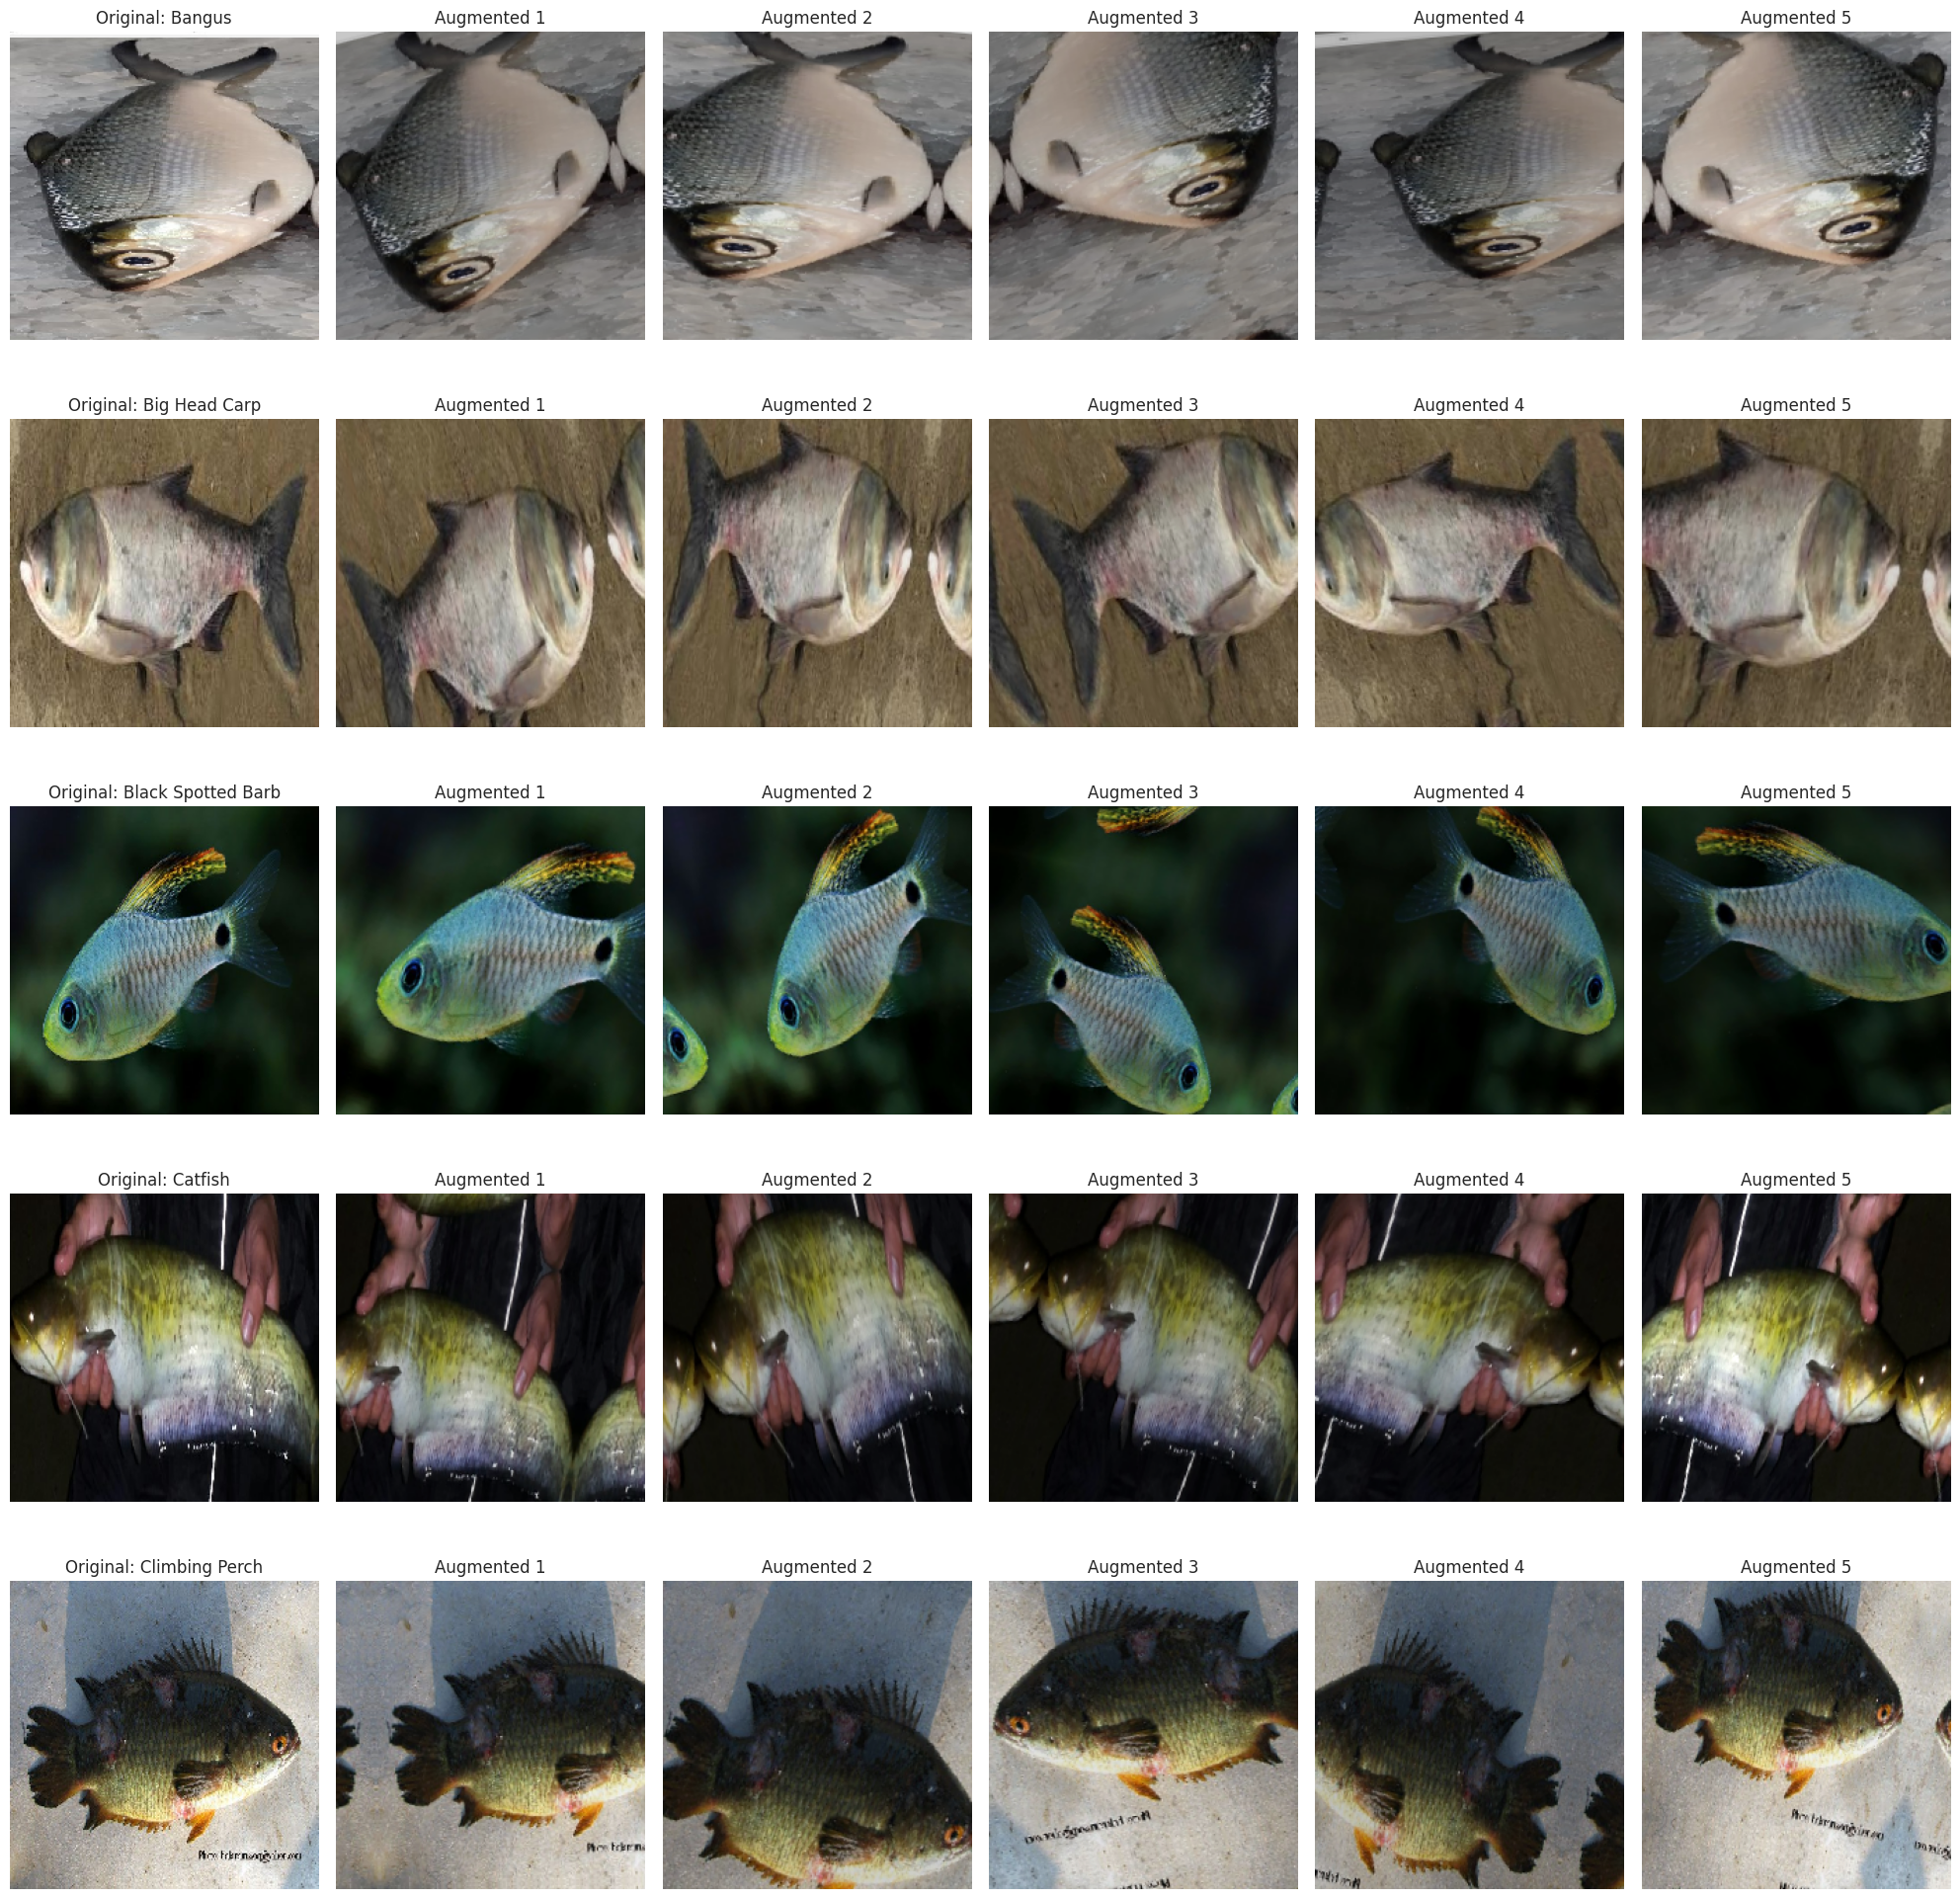

In [8]:
# ======= VISUALISASI AUGMENTASI PER KELAS ==========
def visualize_augmentation(datagen, dataset_path, class_names, num_samples=5):
    plt.figure(figsize=(20, 20))
    for i, fish_type in enumerate(class_names[:min(5, len(class_names))]):
        sample_dir = os.path.join(dataset_path, fish_type)
        if os.path.isdir(sample_dir):
            sample_files = os.listdir(sample_dir)[:1]
            for j, file in enumerate(sample_files):
                img_path = os.path.join(sample_dir, file)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)

                # Gambar asli
                plt.subplot(len(class_names[:min(5, len(class_names))]), num_samples + 1, i * (num_samples + 1) + 1)
                plt.imshow(img)
                plt.title(f"Original: {fish_type}")
                plt.axis('off')

                # Gambar augmentasi
                augm_iterator = datagen.flow(x, batch_size=1)
                for k in range(num_samples):
                    augm_img = next(augm_iterator)[0]
                    plt.subplot(len(class_names[:min(5, len(class_names))]), num_samples + 1, i * (num_samples + 1) + k + 2)
                    plt.imshow(augm_img)
                    plt.title(f"Augmented {k+1}")
                    plt.axis('off')
                break
    plt.tight_layout()
    plt.savefig('data_augmentation_samples.png')
    plt.show()

print("\nVisualisasi augmentasi data...")
visualize_augmentation(train_datagen, train_path, class_names)

# Fine Tuning Pretrained dengan Tensorflow Keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === CONFIG ===
image_size = (224, 224)
batch_size = 32
num_classes = 31
epochs = 20  # no early stopping

# === DATA PREPROCESSING ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,  # ganti dengan path-mu
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,  # ganti dengan path-mu
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # penting untuk evaluasi & confusion matrix
)

# === LOAD BASE MODEL ===
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# === PARTIAL FINE-TUNING ===
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# === ADD CUSTOM HEAD ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# === COMPILE MODEL ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# === TRAINING ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Found 8791 images belonging to 31 classes.
Found 2746 images belonging to 31 classes.
Epoch 1/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 236s 748ms/step - accuracy: 0.0966 - auc: 0.5877 - loss: 3.4148 - val_accuracy: 0.1377 - val_auc: 0.6470 - val_loss: 3.2671
Epoch 2/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 184s 671ms/step - accuracy: 0.1516 - auc: 0.6772 - loss: 3.1630 - val_accuracy: 0.1821 - val_auc: 0.7690 - val_loss: 2.9480
Epoch 3/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 185s 670ms/step - accuracy: 0.1825 - auc: 0.7327 - loss: 3.0136 - val_accuracy: 0.2414 - val_auc: 0.8070 - val_loss: 2.7364
Epoch 4/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 202s 673ms/step - accuracy: 0.2267 - auc: 0.7744 - loss: 2.8484 - val_accuracy: 0.2891 - val_auc: 0.8480 - val_loss: 2.5828
Epoch 5/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 186s 676ms/step - accuracy: 0.2535 - auc: 0.8009 - loss: 2.7296 - val_accuracy: 0.3117 - val_auc: 0.8622 - val_loss: 2.4432
Epoch 6/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 186s 676ms/step - accuracy: 0.2730 - auc: 0.8244 - los

Jumlah kelas: 31
Label kelas: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


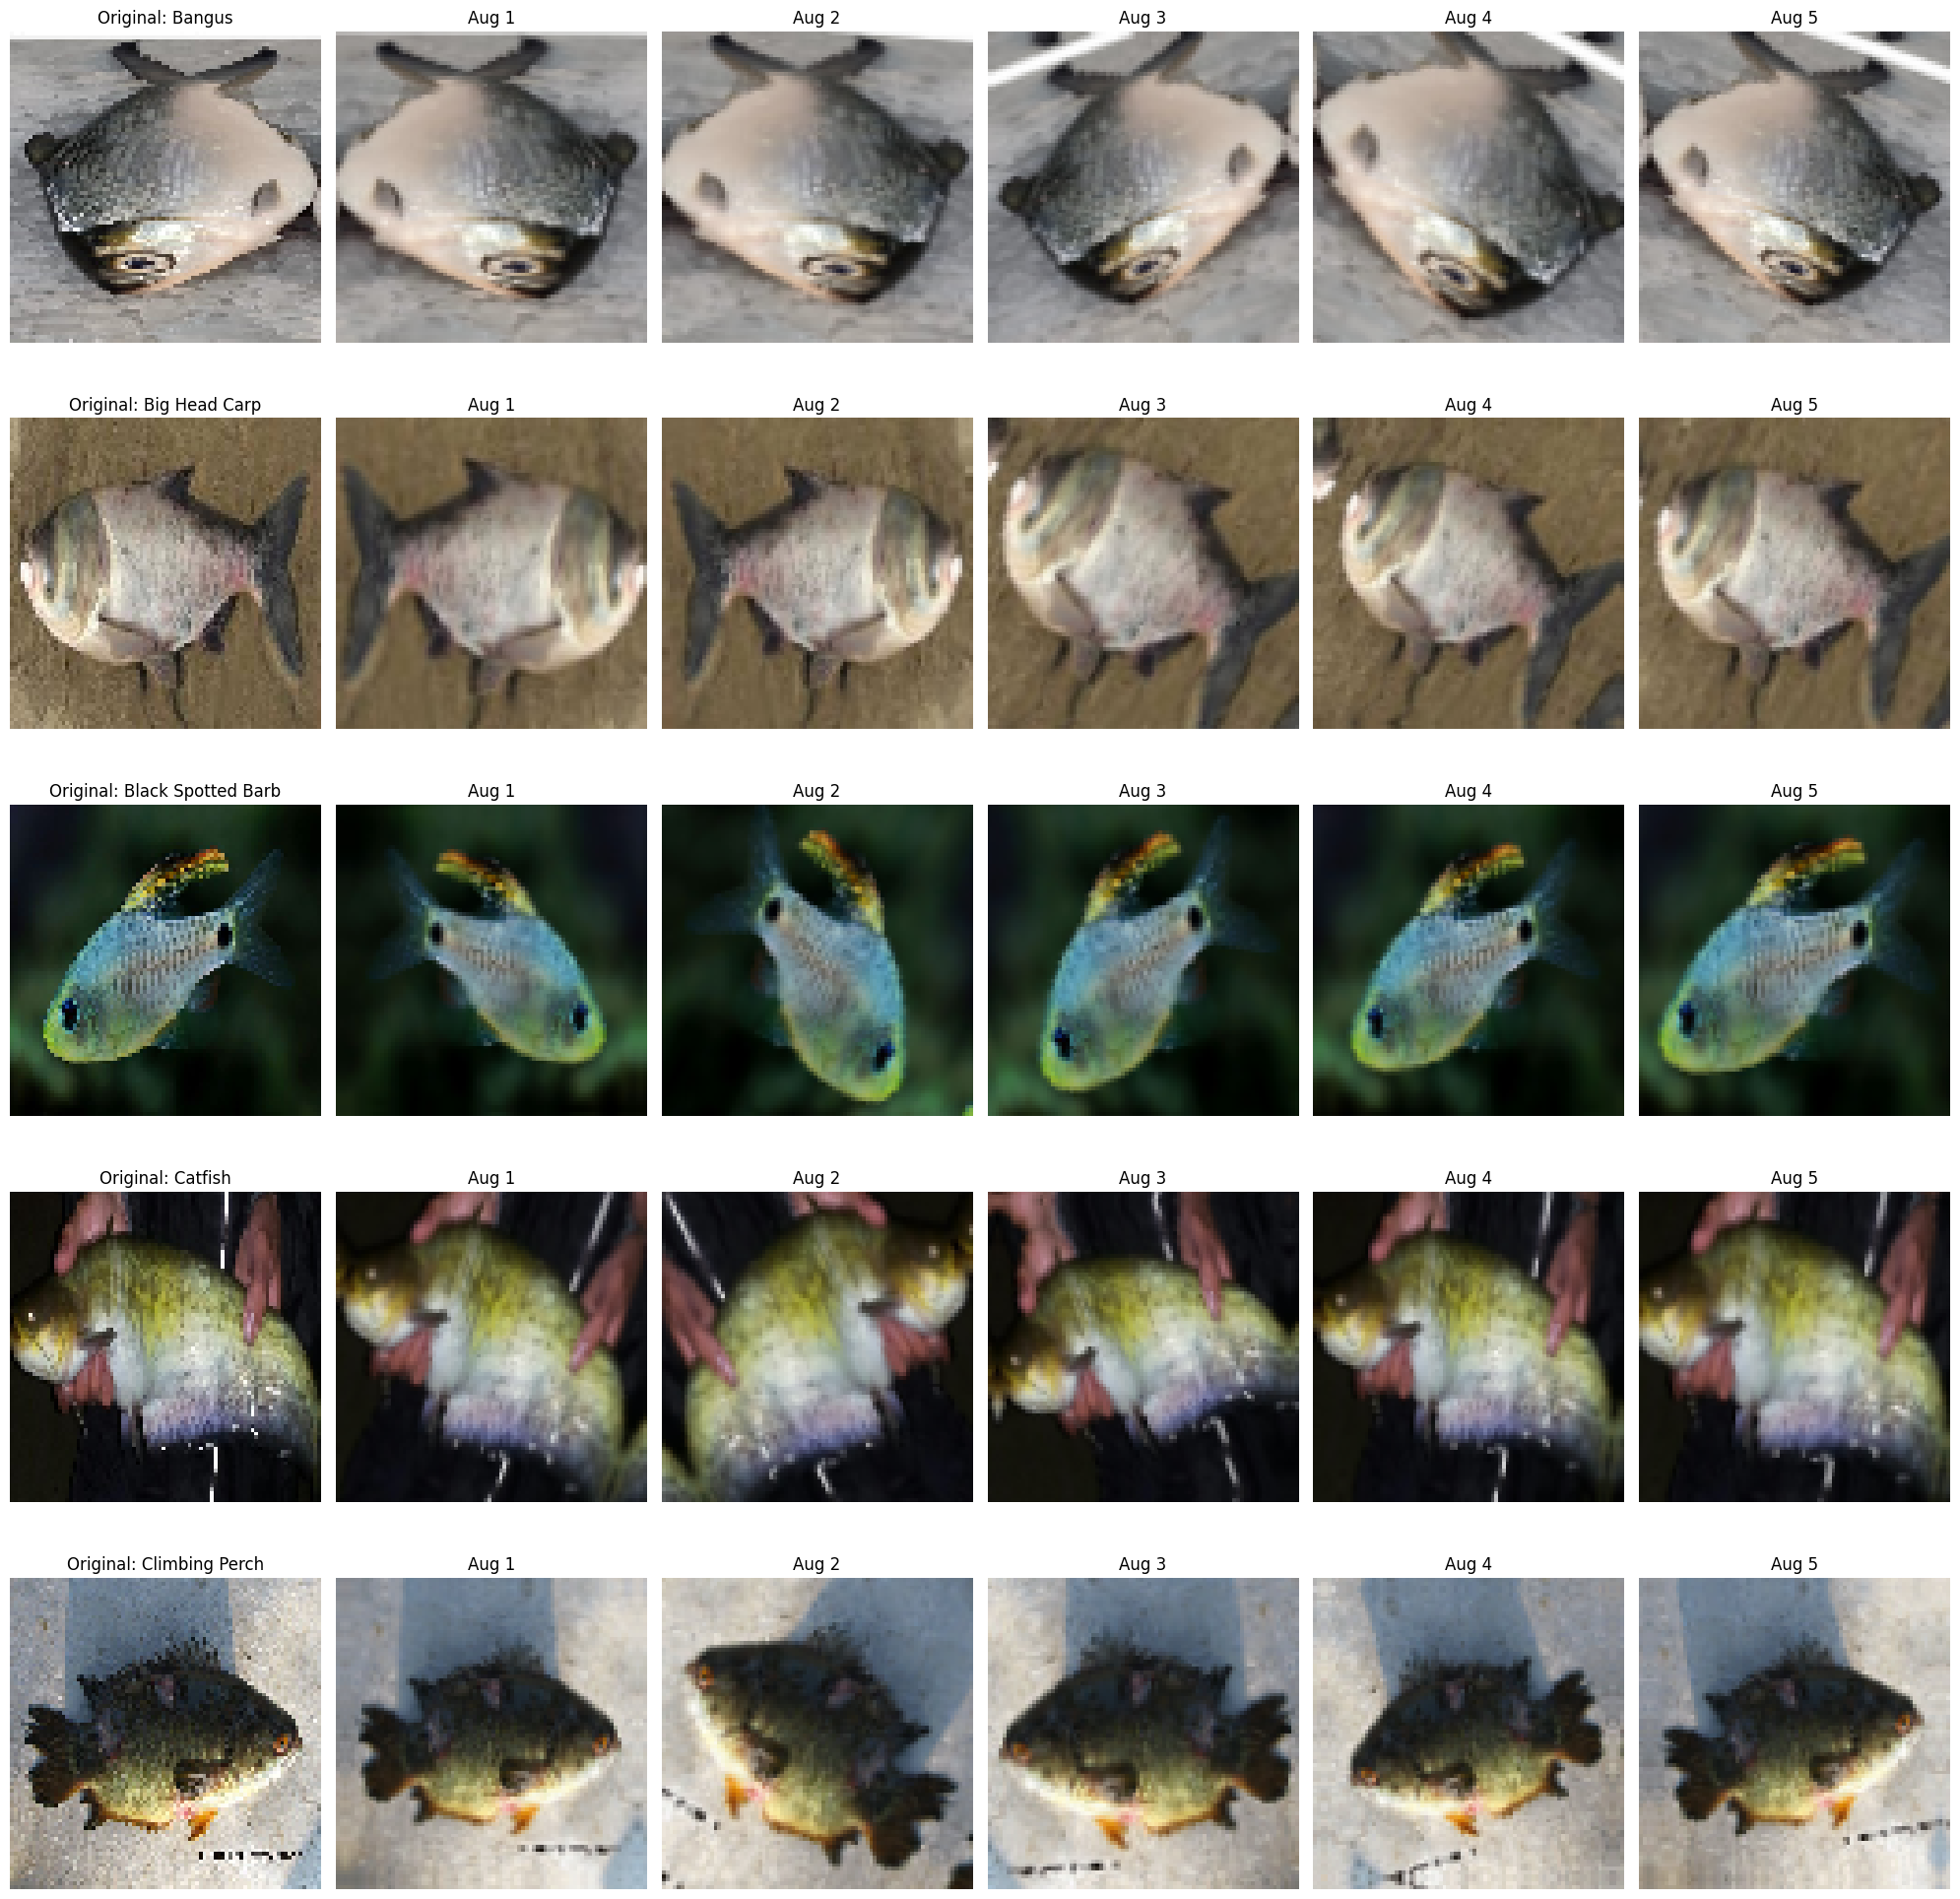

Found 8791 files belonging to 31 classes.
Found 2746 files belonging to 31 classes.
Found 1755 files belonging to 31 classes.
Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1313s 9s/step - accuracy: 0.1820 - loss: 13.2569 - val_accuracy: 0.5816 - val_loss: 1.7428
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5057 - loss: 7.9921 - val_accuracy: 0.6442 - val_loss: 1.3851
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 125s 902ms/step - accuracy: 0.5714 - loss: 6.6917 - val_accuracy: 0.6770 - val_loss: 1.2269
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 154s 989ms/step - accuracy: 0.6062 - loss: 6.0494 - val_accuracy: 0.6963 - val_loss: 1.1273
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 141s 982ms/step - accuracy: 0.6315 - loss: 5.5545 - val_accuracy: 0.7087 - val_loss: 1.0592
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 126s 915ms/step - accuracy: 0.6469 - loss: 5.3322 - val_accuracy: 0.7181 - val_loss: 1.0171
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 150s 973ms/step - accuracy: 0.6610 - loss: 5.0

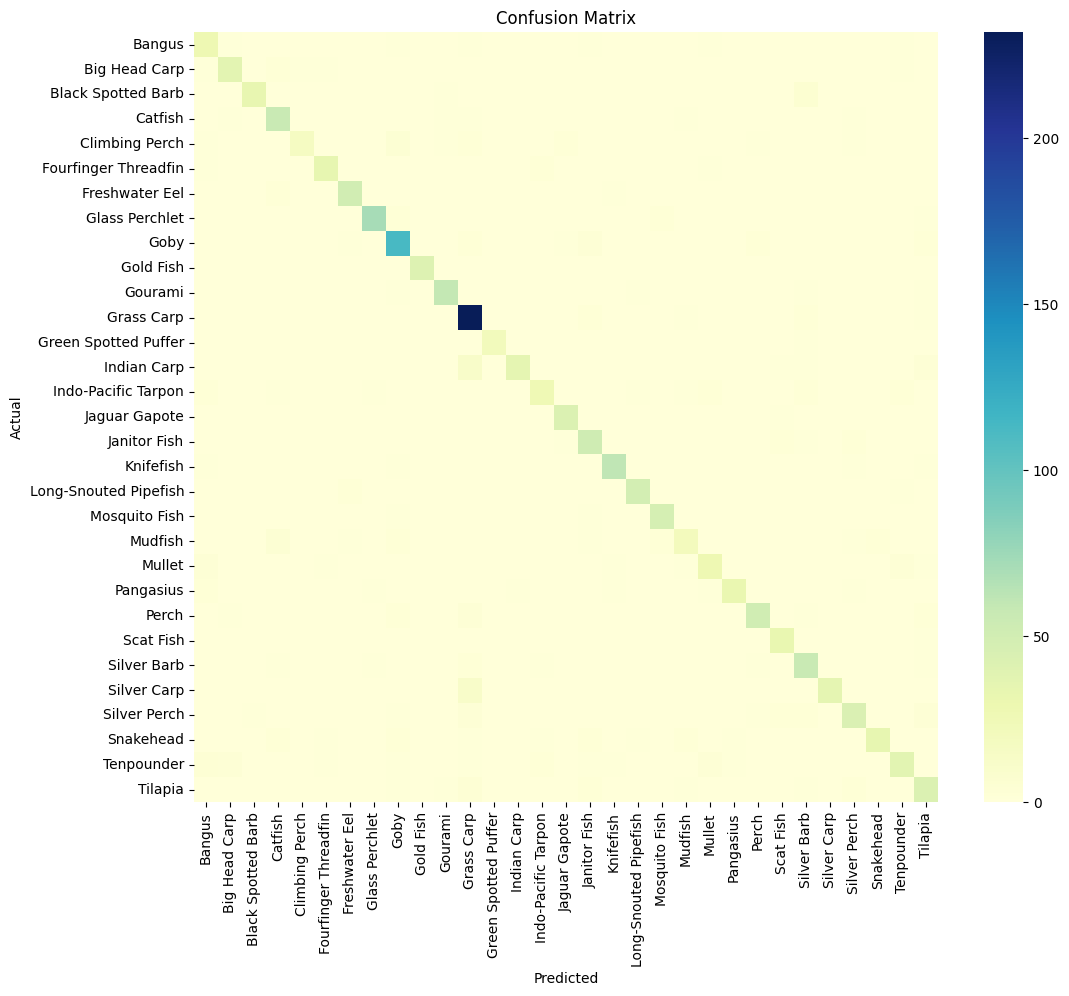

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Konfigurasi direktori
base_path = '/content/drive/MyDrive/fish_image_dataset'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

# Dapatkan nama-nama kelas
label_names = sorted(os.listdir(train_path))
total_classes = len(label_names)
print("Jumlah kelas:", total_classes)
print("Label kelas:", label_names)

# Parameter dataset dan augmentasi
IMAGE_DIM = 84
BATCH = 64
AUTOTUNE = tf.data.AUTOTUNE

# Distribusi data untuk class_weight
class_distribution = {
    'Train': [171, 201, 200, 314, 152, 192, 273, 399, 607, 206, 312, 1222, 110, 262, 186, 229, 286, 319, 256, 256, 191, 174, 193, 293, 154, 329, 238, 285, 232, 277, 302]
}
highest_count = max(class_distribution['Train'])
weights = {i: highest_count / count for i, count in enumerate(class_distribution['Train'])}

# Augmentasi data
augmentor = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Visualisasi augmentasi
def show_augmented_images(data_folder, labels, samples_per_class=5):
    plt.figure(figsize=(20, 20))
    for i, label in enumerate(labels[:5]):
        img_dir = os.path.join(data_folder, label)
        if not os.path.isdir(img_dir):
            continue
        img_files = os.listdir(img_dir)[:1]
        for j, img_file in enumerate(img_files):
            img_path = os.path.join(img_dir, img_file)
            original_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_DIM, IMAGE_DIM))
            img_array = tf.keras.preprocessing.image.img_to_array(original_img)
            img_array = img_array.reshape((1,) + img_array.shape)

            plt.subplot(5, samples_per_class + 1, i * (samples_per_class + 1) + 1)
            plt.imshow(original_img)
            plt.title(f"Original: {label}")
            plt.axis("off")

            for k in range(samples_per_class):
                transformed_img = augmentor(img_array, training=True)[0].numpy().astype("uint8")
                plt.subplot(5, samples_per_class + 1, i * (samples_per_class + 1) + k + 2)
                plt.imshow(transformed_img)
                plt.title(f"Aug {k+1}")
                plt.axis("off")
            break
    plt.tight_layout()
    plt.savefig('augmented_preview.png')
    plt.show()

show_augmented_images(train_path, label_names)

def load_image_dataset(path, use_aug=False):
    # Load dulu dataset asli agar bisa ambil class_names
    original_ds = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        image_size=(IMAGE_DIM, IMAGE_DIM),
        batch_size=BATCH,
        label_mode='int'
    )
    label_names = original_ds.class_names

    # Terapkan augmentasi jika diminta
    if use_aug:
        original_ds = original_ds.map(lambda x, y: (augmentor(x, training=True), y))

    return original_ds.cache().prefetch(buffer_size=AUTOTUNE), label_names

train_set, label_names = load_image_dataset(train_path, use_aug=True)
val_set, _ = load_image_dataset(val_path)
test_set, _ = load_image_dataset(test_path)

# Bangun model
def build_model(n_classes):
    backbone = EfficientNetB0(
        input_shape=(IMAGE_DIM, IMAGE_DIM, 3),
        include_top=False,
        weights='imagenet'
    )
    backbone.trainable = False

    model_output = backbone.output
    model_output = GlobalAveragePooling2D()(model_output)
    model_output = Dropout(0.5)(model_output)
    final_layer = Dense(n_classes, activation='softmax')(model_output)

    model = Model(inputs=backbone.input, outputs=final_layer)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model, backbone

model, backbone = build_model(total_classes)

callbacks_list = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_effnetb0.weights.h5', save_best_only=True, save_weights_only=True)
]

# Training awal
initial_history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,
    callbacks=callbacks_list,
    class_weight=weights
)

# Fine-tuning
backbone.trainable = True
for layer in backbone.layers[:50]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=15,
    callbacks=callbacks_list
)

# Evaluasi model
loss_test, acc_test = model.evaluate(test_set)
print(f"\nAkurasi Uji: {acc_test:.4f}")
print(f"Loss Uji: {loss_test:.4f}")

# Prediksi & metrik
true_labels = []
predicted_probs = []

for batch_imgs, batch_labels in test_set:
    probs = model.predict(batch_imgs)
    true_labels.extend(batch_labels.numpy())
    predicted_probs.extend(probs)

predicted_classes = np.argmax(predicted_probs, axis=1)

# Laporan klasifikasi
print(classification_report(true_labels, predicted_classes, target_names=label_names))

# Ekstraksi metrik
report_data = classification_report(true_labels, predicted_classes, target_names=label_names, output_dict=True)
print("Hasil Evaluasi:")
print(f"Akurasi : {report_data['accuracy']:.4f}")
print(f"Presisi : {report_data['weighted avg']['precision']:.4f}")
print(f"Recall  : {report_data['weighted avg']['recall']:.4f}")
print(f"F1-Score: {report_data['weighted avg']['f1-score']:.4f}")

# Confusion matrix
cmatrix = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cmatrix, annot=False, cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
